In [4]:
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("FC26_20250921.csv", low_memory=False)

cols = [
    'age',
    'league_id', 'league_name',
    'club_team_id', 'club_name',
    'player_positions',
    'value_eur',
    'nationality_id', 'nationality_name',
    'preferred_foot',
    'club_jersey_number'
]
df = df[cols]


ALLOWED_LEAGUE_IDS = [
    53, 19, 16, 31, 13, 350, 68, 39, 10, 14, 308, 7
]

df = df[df['league_id'].isin(ALLOWED_LEAGUE_IDS)]


position_map = {
    'GK': 'Goalkeeper',
    'LB': 'Defense', 'CB': 'Defense', 'RB': 'Defense',
    'LWB': 'Defense', 'RWB': 'Defense',
    'CDM': 'Midfield', 'CM': 'Midfield', 'CAM': 'Midfield',
    'LM': 'Midfield', 'RM': 'Midfield',
    'LW': 'Attack', 'RW': 'Attack',
    'CF': 'Attack', 'ST': 'Attack',
    'LS': 'Attack', 'RS': 'Attack',
    'LF': 'Attack', 'RF': 'Attack'
}

for group in ['Goalkeeper', 'Defense', 'Midfield', 'Attack']:
    df[group] = 0

for idx, positions in df['player_positions'].items():
    if pd.isna(positions):
        continue
    for pos in positions.split(','):
        pos = pos.strip()
        if pos in position_map:
            df.loc[idx, position_map[pos]] = 1

df = df.drop(columns=['player_positions'])


df = df[df['value_eur'] > 0]

df['club_team_id'] = df['club_team_id'].astype(int)
df['league_id'] = df['league_id'].astype(int)
df['nationality_id'] = df['nationality_id'].astype(int)

df['club_jersey_number'] = (
    df['club_jersey_number']
    .fillna(0)
    .astype(int)
)

le = LabelEncoder()
df['preferred_foot'] = le.fit_transform(
    df['preferred_foot'].fillna('Right')
)

df.to_csv("player_value_prepared.csv", index=False)


club_map = (
    df[['club_team_id', 'club_name']]
    .drop_duplicates()
    .set_index('club_team_id')['club_name']
    .to_dict()
)

league_map = (
    df[['league_id', 'league_name']]
    .drop_duplicates()
    .set_index('league_id')['league_name']
    .to_dict()
)

nation_map = (
    df[['nationality_id', 'nationality_name']]
    .drop_duplicates()
    .set_index('nationality_id')['nationality_name']
    .to_dict()
)

with json.dump(club_map, f, ensure_ascii=False, indent=4)

with open('league_map.json', 'w', encoding='utf-8') as f:
    json.dump(league_map, f, ensure_ascii=False, indent=4)

with open('nation_map.json', 'w', encoding='utf-8') as f:
    json.dump(nation_map, f, ensure_ascii=False, indent=4)
 open('club_map.json', 'w', encoding='utf-8') as f:
   



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle


df = pd.read_csv("player_value_prepared.csv")


categorical_ids = ['league_id', 'club_team_id', 'nationality_id']
for col in categorical_ids:
    df[col] = df[col].astype('category')


features = [
    'age',
    'league_id',
    'club_team_id',
    'nationality_id',
    'preferred_foot',
    'club_jersey_number',
    'Goalkeeper', 'Defense', 'Midfield', 'Attack'
]

X = df[features]
y = np.log1p(df['value_eur'])  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {
            "fit_intercept": [True],
            "positive": [False, True]
        }
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            "alpha": [0.1, 1.0, 10.0]
        }
    },
    "Lasso": {
        "model": Lasso(max_iter=5000),
        "params": {
            "alpha": [0.001, 0.01, 0.1]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [200],
            "max_depth": [10, None],
            "min_samples_split": [2, 5]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5]
        }
    }
}


results = {}

for name, mp in models.items():
    print(f"\n--- Training {name} ---")
    
    gs = GridSearchCV(
        mp["model"],
        mp["params"],
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "RMSE_log": rmse,
        "MAE_log": mae,
        "R2": r2,
        "best_params": gs.best_params_
    }
    
 
    with open(f"{name}_best_model.pkl", "wb") as f:
        pickle.dump(best_model, f)


results_df = pd.DataFrame(results).T
print("\n===== FINAL RESULTS =====")
print(results_df)



--- Training LinearRegression ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits

--- Training Ridge ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

--- Training Lasso ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

--- Training RandomForest ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Training GradientBoosting ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits

===== FINAL RESULTS =====
                  RMSE_log   MAE_log        R2  \
LinearRegression  1.230432  0.979504  0.224555   
Ridge             1.230432  0.979502  0.224554   
Lasso             1.230445  0.979463  0.224538   
RandomForest       0.83002  0.646058  0.647131   
GradientBoosting  0.796801  0.616973  0.674811   

                                                        best_params  
LinearRegression         {'fit_intercept': True, 'positive': False}  
Ridge                                                {'alpha': 1.0}  
Lasso           

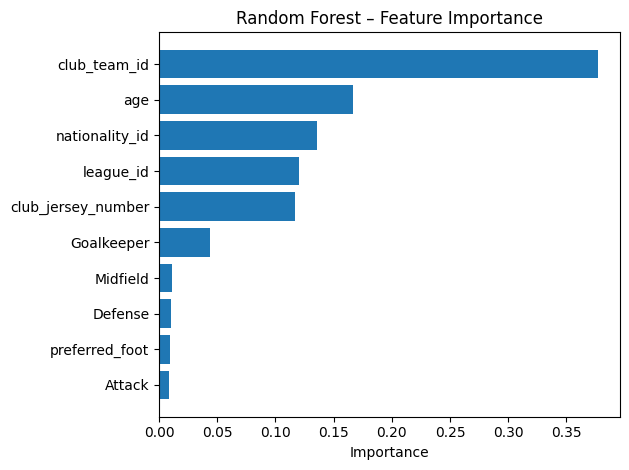

In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt


features = [
    'age', 'league_id', 'club_team_id',
    'nationality_id', 'preferred_foot', 'club_jersey_number',
    'Goalkeeper', 'Defense', 'Midfield', 'Attack'
]


with open("RandomForest_best_model.pkl", "rb") as f:
    rf_model = pickle.load(f)


importances = rf_model.feature_importances_
fi_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


plt.figure()
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest – Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


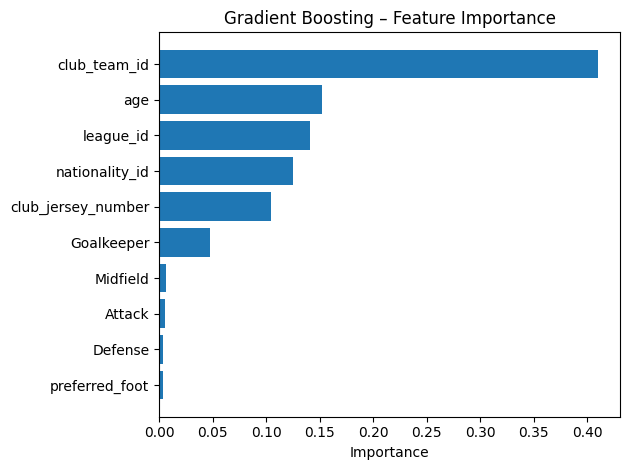

In [7]:

with open("GradientBoosting_best_model.pkl", "rb") as f:
    gb_model = pickle.load(f)


importances = gb_model.feature_importances_
fi_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


plt.figure()
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Gradient Boosting – Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
df = pd.read_csv("player_value_prepared.csv")
len(df)


6494

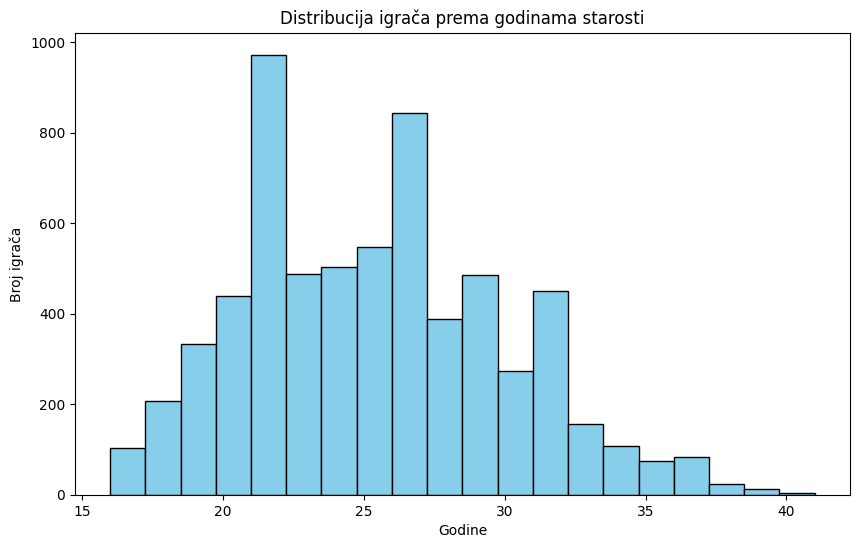

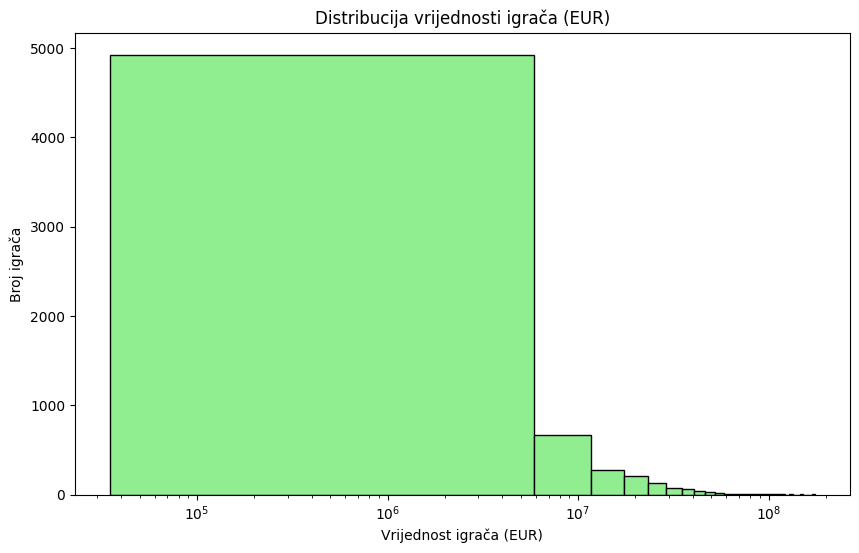

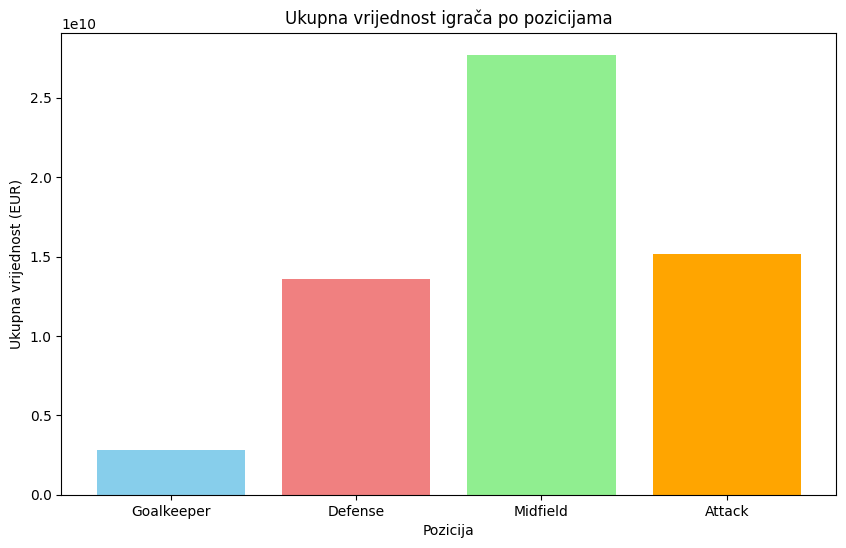

/tmp/ipykernel_3114/2921690468.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=leagues)


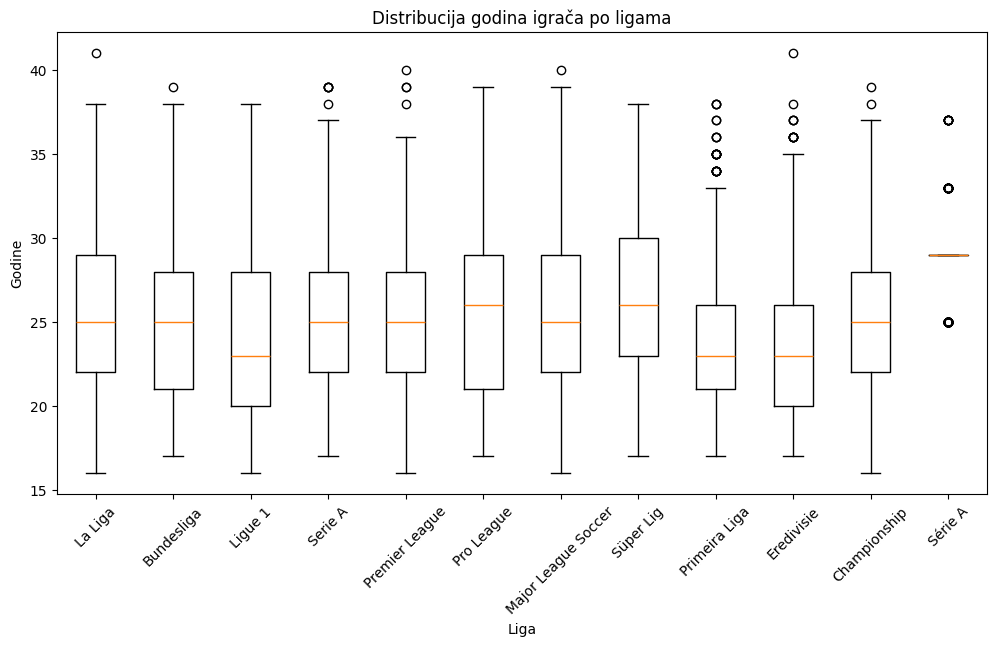

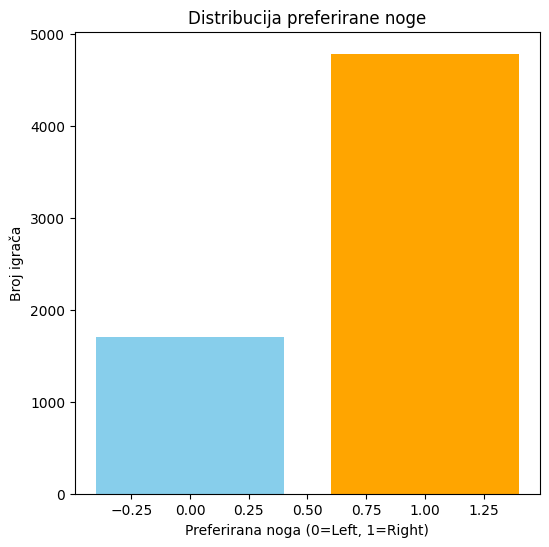

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("player_value_prepared.csv")


plt.figure(figsize=(10,6))
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribucija igrača prema godinama starosti")
plt.xlabel("Godine")
plt.ylabel("Broj igrača")
plt.show()


plt.figure(figsize=(10,6))
plt.hist(df['value_eur'], bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribucija vrijednosti igrača (EUR)")
plt.xlabel("Vrijednost igrača (EUR)")
plt.ylabel("Broj igrača")
plt.xscale('log')  
plt.show()


position_cols = ['Goalkeeper', 'Defense', 'Midfield', 'Attack']
position_values = df[position_cols].multiply(df['value_eur'], axis=0).sum()

plt.figure(figsize=(10,6))
plt.bar(position_values.index, position_values.values, color=['skyblue','lightcoral','lightgreen','orange'])
plt.title("Ukupna vrijednost igrača po pozicijama")
plt.ylabel("Ukupna vrijednost (EUR)")
plt.xlabel("Pozicija")
plt.show()


leagues = df['league_name'].unique()
plt.figure(figsize=(12,6))
data_to_plot = [df[df['league_name']==league]['age'] for league in leagues]
plt.boxplot(data_to_plot, labels=leagues)
plt.title("Distribucija godina igrača po ligama")
plt.xticks(rotation=45)
plt.xlabel("Liga")
plt.ylabel("Godine")
plt.show()


foot_counts = df['preferred_foot'].value_counts()
plt.figure(figsize=(6,6))
plt.bar(foot_counts.index, foot_counts.values, color=['orange','skyblue'])
plt.title("Distribucija preferirane noge")
plt.xlabel("Preferirana noga (0=Left, 1=Right)")
plt.ylabel("Broj igrača")
plt.show()

